### x lines of Python
# Amplitude-vs-offset plot

This notebook accompanies [a blog post at Agile*](http://ageo.co/xlines03).

In the first **x lines** we made a 2D synthetic seismogram. A major simplification in that model was normal incidence at 0 degrees of offset: the ray of seismic energy was assumed to be perfectly vertical. In this notebook, we'll model non-vertical incidence.

When the reflection is not perpendicular to the geological interface, we have to use the Zoeppritz equation, or simplications of it, to model the angle-dependent reflectivity. Agile's library [`bruges`](http://github.com/agile-geoscience/bruges) (Bag of Really Useful Geophysical Equations and Stuff) has lots of different reflectivity formulations to compare; we'll look at three.

The data is from Blangy, JP, 1994, AVO in tranversely isotropic media—An overview. *Geophysics* **59** (5), 775–781. Blangy conveniently defined his model rocks very fully and clearly (take not would-be authors!). Related blog post: [The Blangy equation](http://www.agilegeoscience.com/blog/2014/8/7/the-blangy-equation.html?rq=blangy)

Before we start, the usual prelims:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll initiate some variables with some of Blangy's test data: the Type 3 AVO rocks from his Table 1. We only need the acoustic properties at first, but we'll define the elastic and anisotropic parameters as well, just in case we need them later (we will!).

In [2]:
# Upper layer: shale.
vp0, vs0, ρ0, δ0, ε0 = 2307, 1108, 2150, 0.15, 0.30       # Line 1

# Lower layer: wet sand.
vp1, vs1, ρ1, δ1, ε1 =  1951, 930,  2200, 0.00, 0.00      # Line 2

# Lower layer: gas sand.
vp1g, vs1g, ρ1g, δ1g, ε1g = 1951, 1301, 1950, 0.00, 0.00  # Line 3

For peace of mind, or just for fun, we can make a plot of these properties. 

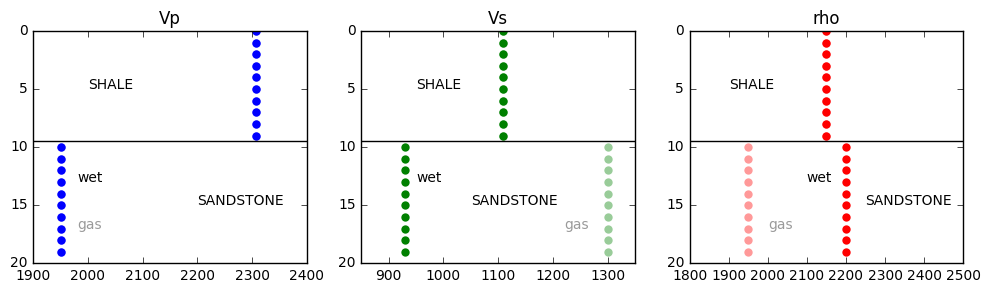

In [3]:
fig = plt.figure(figsize=(12, 3))

z = np.arange(0, 20)

ax0 = fig.add_subplot(1, 3, 1)
ax0.plot(np.append(np.repeat(vp0, 10), np.repeat(vp1, 10)), z, 'ob', markeredgecolor='none')
ax0.plot(np.append(np.repeat(vp0, 10), np.repeat(vp1g, 10)), z, 'ob', alpha=0.4, markeredgecolor='none')
ax0.set_xlim(1900, 2400)
ax0.axhline(9.5, c='k')
ax0.invert_yaxis()
ax0.set_title('Vp')
ax0.text(2000, 5, 'SHALE')
ax0.text(2200, 15, 'SANDSTONE')
ax0.text(1980, 13, 'wet')
ax0.text(1980, 17, 'gas', alpha=0.4)

ax1 = fig.add_subplot(1, 3, 2)
ax1.plot(np.append(np.repeat(vs0, 10), np.repeat(vs1, 10)), z, 'og', markeredgecolor='none')
ax1.plot(np.append(np.repeat(vs0, 10), np.repeat(vs1g, 10)), z, 'og', alpha=0.4, markeredgecolor='none')
ax1.set_xlim(850, 1350)
ax1.axhline(9.5, c='k')
ax1.invert_yaxis()
ax1.set_title('Vs')
ax1.text(950, 5, 'SHALE')
ax1.text(1050, 15, 'SANDSTONE')
ax1.text(950, 13, 'wet')
ax1.text(1220, 17, 'gas', alpha=0.4)

ax2 = fig.add_subplot(1, 3, 3)
ax2.plot(np.append(np.repeat(ρ0, 10), np.repeat(ρ1, 10)), z, 'or', markeredgecolor='none')
ax2.plot(np.append(np.repeat(ρ0, 10), np.repeat(ρ1g, 10)), z, 'or', alpha=0.4, markeredgecolor='none')
ax2.set_xlim(1800, 2500)
ax2.axhline(9.5, c='k')
ax2.invert_yaxis()
ax2.set_title('rho')
ax2.text(1900, 5, 'SHALE')
ax2.text(2250, 15, 'SANDSTONE')
ax2.text(2100, 13, 'wet')
ax2.text(2000, 17, 'gas', alpha=0.4)

plt.show()

## Linear Shuey equation

Let's start with a bit of maths — [the 2-term Shuey approximation](http://subsurfwiki.org/wiki/Shuey_equation). I'm using the formulation given by Avesth, P, T Mukerji and G Mavko (2005). *Quantitative seismic interpretation.* Cambridge University Press, Cambridge, UK. 

$$R(\theta) \approx R(0) + G \sin^2 \theta$$

where

$$R(0) = \frac{1}{2} \left( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right)$$

and

$$G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right)$$

In these equations, $\Delta V_\mathrm{P}$ means the difference in the velocity of the two layers, and $V_\mathrm{P}$ means the mean of the two layers. Let's make a function to help with this 'difference over mean':

In [4]:
# I'm on a tight line budget so I'm defining a function on a
# single line. Don't do this, it makes your code less readable.
def dom(upper, lower): return np.subtract(lower, upper) / np.mean((lower, upper))

First term:

In [5]:
R0 = 0.5 * (dom(vp0, vp1) + dom(ρ0, ρ1))

In [6]:
R0

-0.072113074510185018

OK, that looks reasonable, but the second term $G$ is going to take some really fiddly math... and I'm on a budget, I don't have enough lines for all that. Besides, I might easily make a mistake.

Luckily, our library `bruges` has all these equations. There's a `bruges.reflection.shuey2` function that returns the 2-term Shuey reflectivity for a given interface and angle range.

In [7]:
import bruges

In [8]:
# I have to use 31 because `arange()` goes up to but not including.
θ = range(0, 31)   # Line 4

shuey = bruges.reflection.shuey2(vp0, vs0, ρ0,  # Line 5
                                 vp1, vs1, ρ1,
                                 θ)

I now have an array of the reflection coefficients corresponding to the angles I passed in (0 to 40 degrees of offset).

In [9]:
shuey

array([-0.07211307, -0.07209299, -0.07203278, -0.0719325 , -0.07179227,
       -0.07161228, -0.07139274, -0.07113391, -0.07083612, -0.07049972,
       -0.07012512, -0.06971278, -0.06926321, -0.06877695, -0.06825459,
       -0.06769678, -0.06710418, -0.06647752, -0.06581757, -0.06512512,
       -0.06440103, -0.06364618, -0.06286148, -0.06204788, -0.06120639,
       -0.06033803, -0.05944385, -0.05852495, -0.05758244, -0.05661747,
       -0.05563122])

In [10]:
shuey_g = bruges.reflection.shuey2(vp0,  vs0,  ρ0,  # Line 6
                                   vp1g, vs1g, ρ1g,
                                   θ)

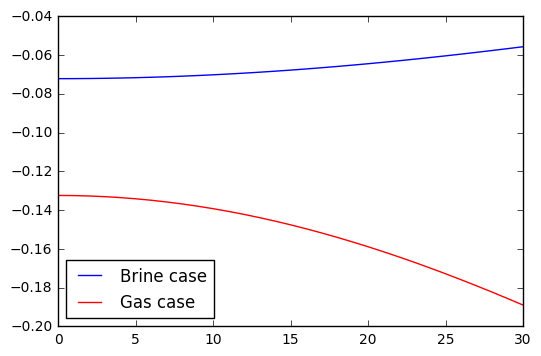

In [11]:
plt.plot(shuey, label='Brine case')         # Line 7
plt.plot(shuey_g, 'red', label='Gas case')  # Line 8
plt.legend(loc='best');                     # Line 9

That's the 10 lines of Python used up, but we already got a useful plot. 

Weith a few more lines, we can make the plot a bit prettier.

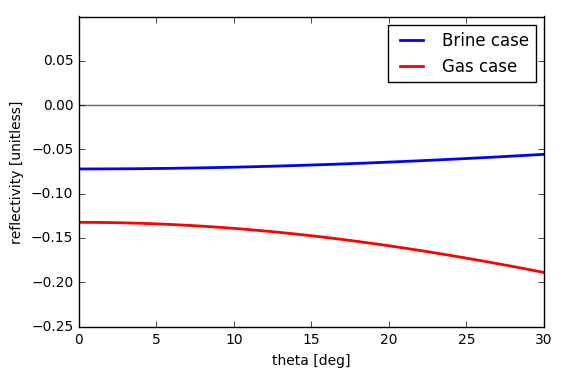

In [12]:
plt.axhline(0, color='k', alpha=0.3)
plt.plot(θ, shuey,  'b', lw=2, label='Brine case')
plt.plot(θ, shuey_g, 'r', lw=2, label='Gas case')
plt.axhline(0, color='k', alpha=0.4)
plt.ylim(-0.25, 0.1)
plt.xlabel('theta [deg]')
plt.ylabel('reflectivity [unitless]')
plt.legend(loc='best')
plt.show()

## Compare to Zoeppritz and Aki-Richards

We could also replace that 2-term Shuey evaluation with another algorithm. For example, let's compute the Aki-Richards approximation and the full Zoeppritz solution, and compare the three results. 

First, we'll make a wider angle range, so we can compare them outside the reliability 'window' of Shuey's approximation (up to about 25 degrees or so for most interfaces).

In [13]:
θ = np.arange(0, 51)

In [14]:
shuey = bruges.reflection.shuey2(vp0,  vs0,  ρ0,
                                 vp1, vs1, ρ1,
                                 θ)

In [15]:
zoeppritz = bruges.reflection.zoeppritz_rpp(vp0, vs0, ρ0,
                                            vp1, vs1, ρ1,
                                            θ)

In [16]:
akirichards = bruges.reflection.akirichards(vp0, vs0, ρ0,
                                            vp1, vs1, ρ1,
                                            θ)

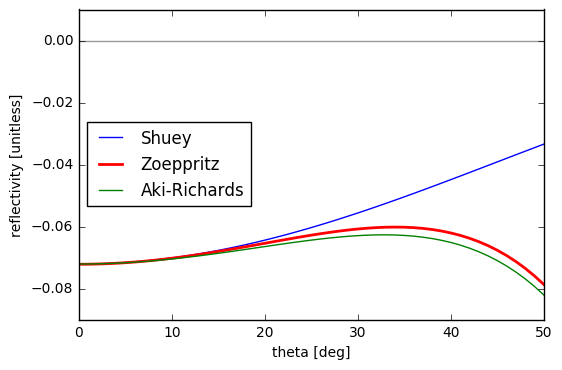

In [17]:
plt.plot(shuey, label='Shuey')
plt.plot(zoeppritz, 'r', lw=2, label='Zoeppritz')
plt.plot(akirichards, label='Aki-Richards')
plt.axhline(0, color='k', alpha=0.4)
plt.xlabel('theta [deg]')
plt.ylabel('reflectivity [unitless]')
plt.legend(loc='best')
plt.show()

You can see how Shuey breaks down at about 25 degrees, whereas Aki-Richards is quite reliable even to wide offsets. 

## Isotropic and anisotropic approximations

We can go further still. Blangy's paper gives us an AVO approximation for weakly anisotropic rocks. We can use another `bruges` function to compute that response. 

In [18]:
# The function returns the isotropic and the anisotropic reponses.
# Since we don't need the isotropic response (it's the same as the
# Aki-Richards solution), we can assign it to _, a sort of throwaway.
_, blangy = bruges.rockphysics.blangy(vp0, vs0, ρ0, δ0, ε0,
                                      vp1, vs1, ρ1, δ1, ε1,
                                      θ)

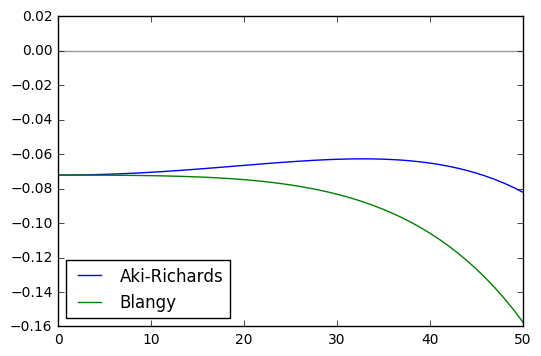

In [19]:
plt.plot(akirichards, label='Aki-Richards')
plt.plot(blangy, label='Blangy')
plt.axhline(0, color='k', alpha=0.4)
plt.legend(loc='best')
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2016</p>
</div>